# Análise de Influenciadores do Instagram usando KNN
## Preparação e Análise Exploratória

In [53]:
# Importação das bibliotecas
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


## Carregamento e Limpeza dos Dados
Aqui carregamos os dados do csv e limpamos as linhas com campos ausentes.

In [54]:
# Carregamento dos dados
df = pd.read_csv('top_insta_influencers_data.csv')
print(df.head())

dfRowsCount = df.size

# retiramos linhas com campos country ausentes
df = df.dropna(subset=['country'])

# Temos então 620 campos ausentes
print(f"\nTemos {dfRowsCount - df.size} campos ausentes")

   rank channel_info  influence_score  posts followers avg_likes  \
0     1    cristiano               92   3.3k    475.8m      8.7m   
1     2  kyliejenner               91   6.9k    366.2m      8.3m   
2     3     leomessi               90  0.89k    357.3m      6.8m   
3     4  selenagomez               93   1.8k    342.7m      6.2m   
4     5      therock               91   6.8k    334.1m      1.9m   

  60_day_eng_rate new_post_avg_like total_likes        country  
0           1.39%              6.5m       29.0b          Spain  
1           1.62%              5.9m       57.4b  United States  
2           1.24%              4.4m        6.0b            NaN  
3           0.97%              3.3m       11.5b  United States  
4           0.20%            665.3k       12.5b  United States  

Temos 620 campos ausentes


## Conversão e ajuste da base de dados
Nessa seção convertemos valores da base de dados, células que aparecem 1k ficarão como 1000. Também convertemos valores que estão em % para ponto flutuante.

Todas as conversões são feitas através do método convert_to_number()

In [55]:
def convert_to_number(value):
    if not isinstance(value, str):
        return value
        
    try:
        # Handle percentage values
        if '%' in value:
            return float(value.replace('%', '')) / 100.0
            
        # Handle k, m, b suffixes    
        if 'k' in value.lower():
            return int(float(value.replace('k', '')) * 1e3)
        elif 'm' in value.lower():
            return int(float(value.replace('m', '')) * 1e6)
        elif 'b' in value.lower():
            return int(float(value.replace('b', '')) * 1e9)
            
        return float(value)
        
    except (ValueError, AttributeError):
        return np.nan

# Convert all columns in one pass
columns_to_convert = ['posts', 'followers', 'avg_likes', 'new_post_avg_like', 'total_likes', '60_day_eng_rate']
for col in columns_to_convert:
    df[col] = df[col].apply(convert_to_number)

# Verify conversion
print("\nSample of converted values:")
print(df[columns_to_convert].head())


Sample of converted values:
   posts  followers  avg_likes  new_post_avg_like  total_likes  \
0   3300  475800000    8700000          6500000.0  29000000000   
1   6900  366200000    8300000          5900000.0  57400000000   
3   1800  342700000    6200000          3300000.0  11500000000   
4   6800  334100000    1900000           665300.0  12500000000   
5   5600  329200000    3500000          2900000.0  19900000000   

   60_day_eng_rate  
0           0.0139  
1           0.0162  
3           0.0097  
4           0.0020  
5           0.0088  


## Mapeamento de Continentes
Nessa seção, mapeamos cada país para o respectivo continente, o que facilida a classificação e evita lidar com multiplos campos. Nas nossas análises, olharemos agora para o continente e não para o país específico.

In [56]:
# Mapeamento de continentes
continent_mapping = {
    # America do Norte
    'United States': 1, 'Canada': 1, 'Mexico': 1, 'Puerto Rico': 1,
    
    # America do Sul
    'Brazil': 2, 'Colombia': 2, 'Argentina': 2, 'Uruguay': 2,
    
    # Europa
    'Spain': 3, 'United Kingdom': 3, 'France': 3, 'Germany': 3,
    'Italy': 3, 'Netherlands': 3, 'Sweden': 3, 'Russia': 3,
    
    # Asia
    'India': 4, 'Indonesia': 4, 'United Arab Emirates': 4,
    
    # Oceania
    'Australia': 5
}

df['continent_code'] = df['country'].map(continent_mapping)
df = df.dropna(subset=['continent_code'])

## Análise Exploratória
Nessa seção, fazemos a analise exploratória, plotando gráficos que ilustram coisas como a distribuição de influenciadores por conteintente, Seguidores x Média de Likes, a taxa de engajamento por continente e a matriz de correlação. 


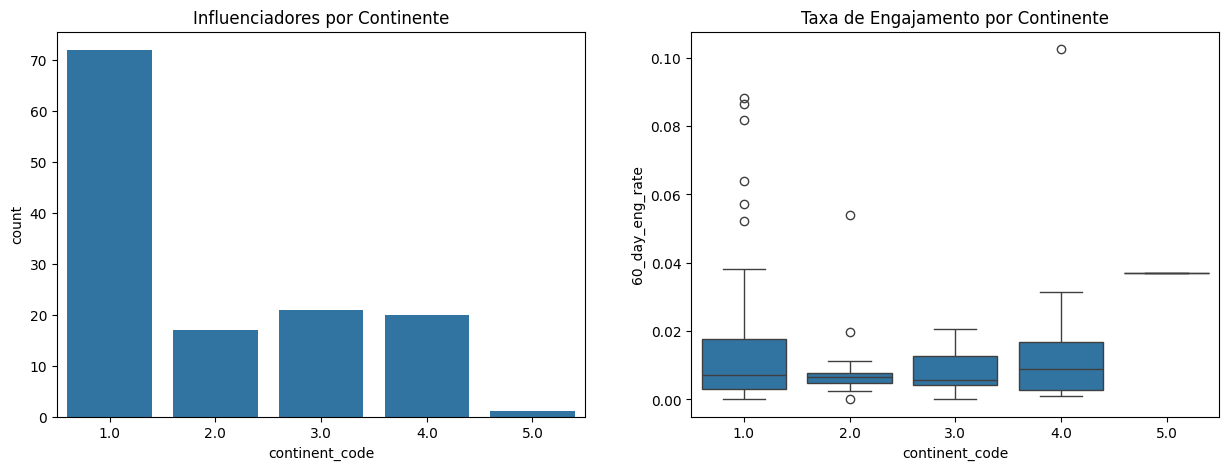

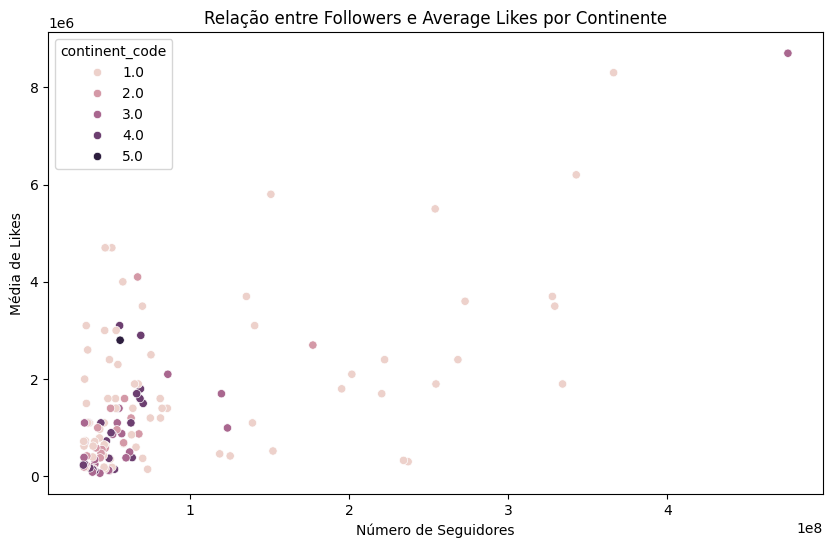

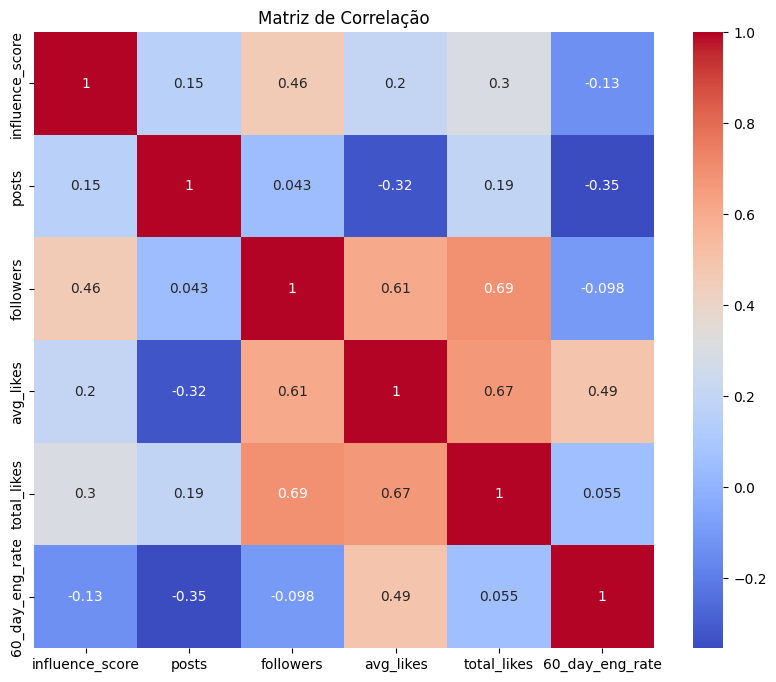

<Figure size 640x480 with 0 Axes>

In [ ]:
# Visualizações
plt.figure(figsize=(15, 5))

# Distribuição de influenciadores por continente
plt.subplot(1, 2, 1)
sns.countplot(data=df, x='continent_code')
plt.title('Influenciadores por Continente')

# Taxa de engajamento por continente
plt.subplot(1, 2, 2)
sns.boxplot(data=df, x='continent_code', y='60_day_eng_rate')
plt.title('Taxa de Engajamento por Continente')


# Análise da relação followers vs avg_likes
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='followers', y='avg_likes', hue='continent_code')
plt.title('Relação entre Followers e Average Likes por Continente')
plt.xlabel('Número de Seguidores')
plt.ylabel('Média de Likes')
plt.show()


# Adicionar análise de correlação
plt.figure(figsize=(10, 8))
sns.heatmap(df[['influence_score', 'posts', 'followers', 'avg_likes', 'total_likes'] + ['60_day_eng_rate']].corr(), annot=True, cmap='coolwarm')
plt.title('Matriz de Correlação')
plt.show()


plt.tight_layout()
plt.show()

## Preparação para o KNN
Nessa seção, selecionamos as features que serão normalizadas e levadas em consideração para a implementação do KNN. Também normalizamos os dados usando MinMaxScaler() e dividimos os dados para 80% treino e 20% teste.


In [ ]:
 #Preparar features e target
features = ['influence_score', 'posts', 'followers', 'avg_likes', 'total_likes']
X = df[features]
y = df['60_day_eng_rate']

# Normalização dos dados
min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(df[['posts', 'followers', 'avg_likes','new_post_avg_like','60_day_eng_rate']])
normalized_df = pd.DataFrame(X_scaled, columns=['posts', 'followers', 'avg_likes','new_post_avg_like','60_day_eng_rate'])

X_scaled_df = pd.DataFrame(X_scaled, columns=features)

print(f"\nAqui está a base de dados normalizada:\n", X_scaled_df.head())

# Dividisão dados de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


Aqui está a base de dados normalizada:
    influence_score     posts  followers  avg_likes  total_likes
0         0.187643  1.000000   1.000000   1.000000     0.134766
1         0.393593  0.752596   0.953676   0.907692     0.157227
2         0.101831  0.699549   0.710477   0.507692     0.093750
3         0.387872  0.680135   0.212498   0.102354     0.018555
4         0.319222  0.669074   0.397793   0.446154     0.084961


## Treinamento e Avaliação do Modelo
Nessa seção, implementamos o modelo de regressão knn, utilizndo grid_search.best_params_['n_neighbors'] que testa autmoticamente vários valores de K para o modelo e escolhe o melhor deles.
Como é possível ver no log abaixo da célula, o melhor K encontrado é K=3.

In [59]:

# Grid Search para encontrar melhor k
param_grid = {'n_neighbors': range(1, 21)}
grid_search = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5)
grid_search.fit(X_train, y_train)

print(f"Melhor k: {grid_search.best_params_['n_neighbors']}")

# Treinar modelo final
knn = KNeighborsRegressor(n_neighbors=grid_search.best_params_['n_neighbors'])
knn.fit(X_train, y_train)

# aplicar a predição do modelo aos dados de teste
y_pred = knn.predict(X_test)


Melhor k: 3


## Análise e visualização dos resultados

Aqui printamos as métricas de avaliação: MAE, MSE, RMSE e também R2 e então plotamos o gráfico comparativo entre os velores reais da taxa de engajamento e os valores previstos pelo modelo.

Em seguida, plotamos os Gráficos de dispersão de followers vs avg_likes e Gráficos de barras comparando rank com influence_score.

Curiosidade: Para fins de testes, quando submetimos ao modelo dados sem a normalização, o resultado foi um R2 de 0.46, manos metade do que conseguimos com os dados normalizados (0.96).


Métricas de Avaliação:
MAE: 0.0034
MSE: 0.0000
RMSE: 0.0047
R2 Score: 0.9607


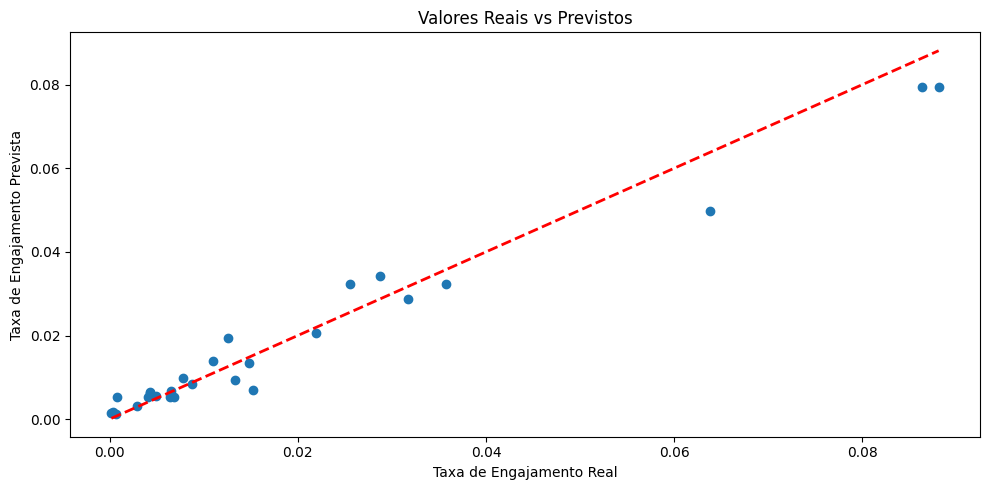


Resultados da Validação Cruzada:
Média: 0.3092
Desvio Padrão: 1.2355


In [60]:
print(f"\nMétricas de Avaliação:")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")
print(f"R2 Score: {r2_score(y_test, y_pred):.4f}")

# Visualizar resultados
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Taxa de Engajamento Real')
plt.ylabel('Taxa de Engajamento Prevista')
plt.title('Valores Reais vs Previstos')
plt.tight_layout()
plt.show()

# Adicionar validação cruzada
cv_scores = cross_val_score(knn, X_scaled, y, cv=5)
print("\nResultados da Validação Cruzada:")
print(f"Média: {cv_scores.mean():.4f}")
print(f"Desvio Padrão: {cv_scores.std():.4f}")
